Vamos começar importando as dependências que serão utilizadas ao longo do trabalho


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Agora vamos implementar um dos algoritmos de envoltória convexa vistos em sala de aula. Mais especificamente, vamos implementar o algoritmo embrulho para presente visto na aula 05.

In [2]:
"""
    Esta função determina a orientação dos pontos (p, q, r).
    Retorna valores:
    0 : Colinear
    1 : Sentido horário
    2 : Sentido anti-horário
"""
def orientation(p, q, r):
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0: return 0
    return 1 if val > 0 else 2

def gift_wrapping(points):
    n = len(points)

    # Encontrar o ponto mais à esquerda
    l = 0
    for i in range(1, n):
        if points[i][0] < points[l][0]:
            l = i

    hull = []
    p = l
    while True:
        hull.append(p)

        q = (p + 1) % n
        for i in range(n):
            if orientation(points[p], points[i], points[q]) == 2:
                q = i

        p = q
        if p == l:
            break

    return [points[i] for i in hull]


# Algoritmo de envoltória convexa
def convex_hull(points):
    return gift_wrapping(points)

Agora vamos criar um conjunto de pontos aleatórios para testar o nosso algoritmo e validá-lo.

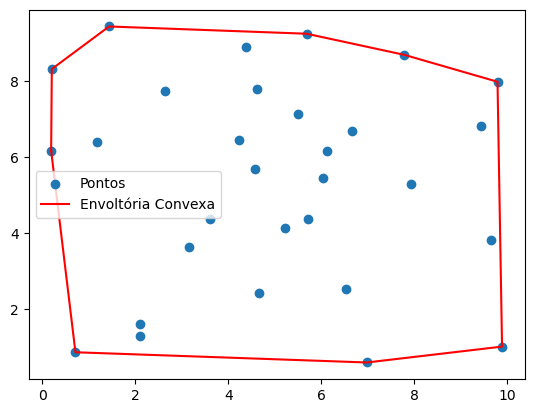

In [3]:
np.random.seed(0)
# Geração de pontos aleatórios
points = np.random.rand(30, 2) * 10

# Encontrar a envoltória convexa
convex_hull_exemple = convex_hull(points)

# Plotar os pontos e a envoltória convexa
plt.scatter(points[:, 0], points[:, 1], label='Pontos')
convex_hull_exemple.append(convex_hull_exemple[0])  # Adicionar o primeiro ponto ao final para fechar o polígono
convex_hull_exemple = np.array(convex_hull_exemple)
plt.plot(convex_hull_exemple[:, 0], convex_hull_exemple[:, 1], 'r-', label='Envoltória Convexa')
plt.legend()
plt.show()

Como podemos ver, o algoritmo funcionou perfeitamente para o conjunto de pontos aleatórios gerados. Com isso podemos seguir adiante para o próximo passo do trabalho que envolve implementar o algoritmo  de varredura linear para detecção de interseções em
conjuntos de segmentos. Vamos utilizar isso para, dado duas envoltórias convexas, determinar se elas se intersectam ou não.


In [4]:

def on_segment(p, q, r):
    return (q[0] <= max(p[0], r[0]) and q[0] >= min(p[0], r[0]) and
            q[1] <= max(p[1], r[1]) and q[1] >= min(p[1], r[1]))

def do_intersect(p1, q1, p2, q2):
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    if o1 == 0 and on_segment(p1, p2, q1): return True
    if o2 == 0 and on_segment(p1, q2, q1): return True
    if o3 == 0 and on_segment(p2, p1, q2): return True
    if o4 == 0 and on_segment(p2, q1, q2): return True

    return False

# Algoritmo de varredura linear para detecção de interseções
def check_intersection(hull1, hull2):
    for i in range(len(hull1) - 1):
        for j in range(len(hull2) - 1):
            p1, q1 = hull1[i], hull1[i + 1]
            p2, q2 = hull2[j], hull2[j + 1]
            if do_intersect(p1, q1, p2, q2):
                return True
    return False

Com isso podemos facilmente escrever um algoritmo de verificação de separabilidade linear. Basta, como foi dito antes, chamar a função acima para os conjuntos de segmentos que formam as envoltórias convexas de cada "classe".

In [5]:
# Verificação de separabilidade linear
def check_linear_separability(X, y):
    class1_points = X[y == 0]
    class2_points = X[y == 1]

    hull1 = convex_hull(class1_points)
    hull2 = convex_hull(class2_points)

    return not check_intersection(hull1, hull2)

Vamos fazer uma pequena validação desses dois ultimos algoritmos com a ajuda de um exemplo simples: dois quadrados que se intersectam.

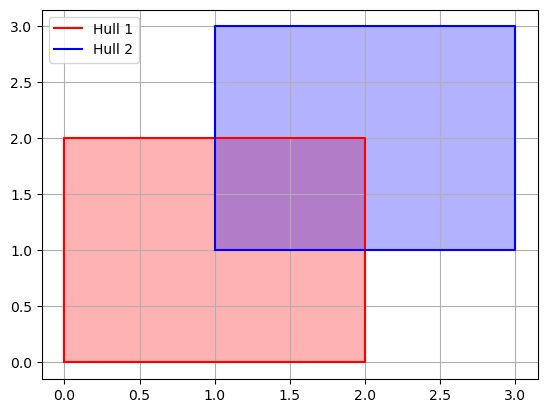

As envoltórias se intersectam.


In [6]:
hull1 = [(0, 0), (0, 2), (2, 2), (2, 0), (0, 0)]
hull2 = [(1, 1), (1, 3), (3, 3), (3, 1), (1, 1)]

hull1_x, hull1_y = zip(*hull1)
hull2_x, hull2_y = zip(*hull2)

plt.figure()
plt.plot(hull1_x, hull1_y, 'r-', label='Hull 1')
plt.plot(hull2_x, hull2_y, 'b-', label='Hull 2')
plt.fill(hull1_x, hull1_y, 'r-', alpha=0.3)
plt.fill(hull2_x, hull2_y, 'b-', alpha=0.3)
plt.legend()
plt.grid(True)
plt.show()

if check_intersection(hull1, hull2):
    print("As envoltórias se intersectam.")
else:
    print("As envoltórias não se intersectam.")

Inclinação da curva: -1.0
Ponto médio: (3.0, 3.0)


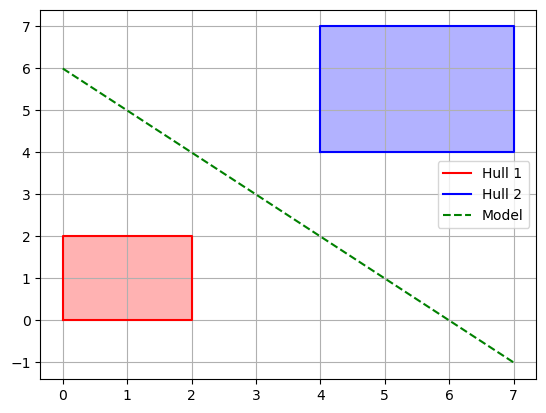

In [7]:
def euclidean_distance(point1, point2):
    point1 = np.array(point1)
    point2 = np.array(point2)
    return np.sqrt(np.sum((point1 - point2)**2))

def build_model(hull1, hull2):
    min_distance = float('inf')
    closest_points = (None, None)

    for p1 in hull1:
        for p2 in hull2:
            distance = euclidean_distance(p1, p2)
            if distance < min_distance:
                min_distance = distance
                closest_points = (p1, p2)

    p1, p2 = closest_points
    midpoint = ((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)

    # Calculando a inclinação da reta perpendicular

    if p2[0] - p1[0] == 0:
        slope = None  # Reta vertical
    else:
        slope = - (p1[0] - p2[0]) / (p1[1] - p2[1])
    #print("Closest Points:", closest_points)
    return slope, midpoint

# Exemplo

hull1 = [(0, 0), (0, 2), (2, 2), (2, 0), (0, 0)]
hull2 = [(4, 4), (4, 7), (7, 7), (7, 4), (4, 4)]


hull1_x, hull1_y = zip(*hull1)
hull2_x, hull2_y = zip(*hull2)

slope, midpoint = build_model(hull1[:-1], hull2[:-1])

print(f"Inclinação da curva: {slope}")
print(f"Ponto médio: {midpoint}")

x_line = np.linspace(min(hull1_x + hull2_x), max(hull1_x + hull2_x), 400)
y_line = slope * (x_line - midpoint[0]) + midpoint[1]

plt.figure()
plt.plot(hull1_x, hull1_y, 'r-', label='Hull 1')
plt.plot(hull2_x, hull2_y, 'b-', label='Hull 2')
plt.plot(x_line, y_line, 'g--', label='Model')
plt.fill(hull1_x, hull1_y, 'r-', alpha=0.3)
plt.fill(hull2_x, hull2_y, 'b-', alpha=0.3)

plt.legend()
plt.grid(True)
plt.show()

In [8]:
def classify(point, slope, midpoint):

    if slope is None:  # Reta vertical
        return 0 if point[0] < midpoint[0] else 1

    y = slope * (point[0] - midpoint[0]) + midpoint[1]

    return 0 if point[1] < y else 1

# Exemplo de uso
test_points = [(1.5, 1.5), (2.5, 2.5), (3.5, 3.5), (4.5,4.5)]
labels = [classify(point, slope, midpoint) for point in test_points]

print(f"Classificação para cada ponto de teste: {labels}")

Classificação para cada ponto de teste: [0, 0, 1, 1]


Com isso, temos todas as funções que precisamos para classificar um conjunto de dados real. O passo a passo para concluir o trabalho é:



1.   Carregar o conjunto de dados e dividi-lo em conjuntos de treinamento e teste.
2.   Separar os pontos de treinamento em duas classes com base nos rótulos.
3. Calcular as envoltórias convexas para cada classe usando o algoritmo embrulho para presente já implementado.
4. Verificar se as envoltórias se intersectam usando o algoritmo de varredura linear também já implementado.
5. Se as envoltórias não se intersectam (ou seja, os dados são linearmente separáveis), construir o modelo linear.
6. Usar o modelo para classificar os pontos no conjunto de teste.




In [9]:
def process_dataset(X,y,className1 = 0, className2 = 1):

  # Dividir os dados em conjuntos de treino e teste (70% treino e 30% teste)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  # Separar os pontos de treinamento em duas classes
  class1_points = X_train[y_train == className1]
  class2_points = X_train[y_train == className2]

  test_class1_points = X_test[y_test == className1]
  test_class2_points = X_test[y_test == className2]

  # Calcular as envoltórias convexas
  hull1 = convex_hull(class1_points.to_numpy())

  hull2 = convex_hull(class2_points.to_numpy())

  # Plotar as envoltórias
  hull1_x, hull1_y = zip(*hull1)
  hull2_x, hull2_y = zip(*hull2)

  plt.figure()
  plt.plot(hull1_x, hull1_y, 'r-', label='Hull 1')
  plt.plot(hull2_x, hull2_y, 'b-', label='Hull 2')
  plt.fill(hull1_x, hull1_y, 'r-', alpha=0.3)
  plt.fill(hull2_x, hull2_y, 'b-', alpha=0.3)
  plt.legend()
  plt.grid(True)
  plt.show()

  # Verificar se as envoltórias se intersectam
  if check_intersection(hull1, hull2):
      print("Os dados não são linearmente separáveis.")
  else:
      print("Os dados são linearmente separáveis.")
      slope, midpoint = build_model(hull1, hull2)
      #print(slope, midpoint)
      # Classificar os pontos no conjunto de teste
      X_test_numpy = X_test.to_numpy()
      y_pred = [classify(point, slope, midpoint) for point in X_test_numpy]
      y_pred = np.array(y_pred, dtype=y_test.dtype)

      # Calcular a acurácia
      accuracy = np.mean(y_pred == y_test)
      print(f"Acurácia do modelo: {accuracy * 100:.2f}%")

      # Plotar as envoltórias e a reta modelo
      hull1_x, hull1_y = zip(*hull1)
      hull2_x, hull2_y = zip(*hull2)

      plt.figure()
      plt.scatter(test_class1_points.iloc[:, 0], test_class1_points.iloc[:, 1], c='r', label='Classe 1')
      plt.scatter(test_class2_points.iloc[:, 0], test_class2_points.iloc[:, 1], c='b', label='Classe 2')
      plt.fill(hull1_x, hull1_y, 'r-', alpha=0.3)
      plt.fill(hull2_x, hull2_y, 'b-', alpha=0.3)
      plt.plot(hull1_x, hull1_y, 'r-', alpha=0.6)
      plt.plot(hull2_x, hull2_y, 'b-', alpha=0.6)

      if slope is not None:
          x_vals = np.linspace(min(X_train.iloc[:, 0]), max(X_train.iloc[:, 0]), 400)
          y_vals = slope * (x_vals - midpoint[0]) + midpoint[1]
      else:
          x_vals = [midpoint[0]] * 400
          y_vals = np.linspace(min(X_train.iloc[:, 1]), max(X_train.iloc[:, 1]), 400)

      plt.plot(x_vals, y_vals, 'g--', label='Modelo')
      plt.legend()
      plt.grid(True)
      plt.show()
      y_test = y_test.dropna()

      # Calcular as métricas usando Scikit-Learn
      precision = precision_score(y_test, y_pred)
      recall = recall_score(y_test, y_pred)
      f1 = f1_score(y_test, y_pred)

      print(f"Precisão: {precision:.2f}")
      print(f"Revocação: {recall:.2f}")
      print(f"F1-Escore: {f1:.2f}")

O método acima é o que será utilizado para todos os datasets a seguir para realizar as tarefas discutidas anteriormente. Note que vamos considerar uma classificação binária nesse método entre o className1 e o className2 (que serão 0 e 1 para todos os casos abaixo, ou seja, todos os casos abaixo realizarão o pré processamento). Se os dados não forem linearmente separáveis, apenas a imagem mostrando isso e o alerta serão exibidos. Caso contrário, mostraremos a imagem provando que os dados são linearmente separáveis, calcularemos a reta referente a divisão de classes e classificaremos os dados de teste com base nesse modelo "treinado". Exibiremos a imagem dos dados separados linearmente, com a respectiva reta e com as métricas pedidas (f1-score, acurácia, precisão e revocação).

Vamos discutir um pouco como os resultados serão exibidos a seguir. Primeiramente, para cada dataset será gerado um gráfico com o "modelo", ou seja, com a envoltória convexa dos conjuntos de treinamento para cada classe. Isso será utilizado para verificarmos visualmente que os dados são linearmente separáveis ou que não são. Em caso positivo, mostraremos outro gráfico com a envoltória convexa dos dados de treinamento, a reta mediatriz dos pontos mais próximos de cada envoltória e os pontos que representam os conjuntos de teste coloridos de acordo com suas classes extraídas do dataset. O valor predito para cada um desses pontos vai ser determinado pelo lado que eles estão em relação à mediatriz. Se estiverem do mesmo lado da envoltória convexa de mesma cor, significa que o valor predito corresponde ao valor original, caso contrário não corresponde.

Antes de testarmos em datasets reais, aplicaremos um procedimento para transformar nosso conjunto em bidimensional. Faremos isso através do uso de uma Random Forest e a métrica feature importance: que representa o percentual de relevância de cada coluna do conjunto para prever um determinado target. Selecionaremos as duas mais relevantes para cada conjunto antes de executar nosso classificador.

In [10]:
from sklearn.ensemble import RandomForestClassifier

def reduce_dimesionality(X, y):
    rf = RandomForestClassifier()
    rf.fit(X, y)
    feat_importance = pd.DataFrame({'feat':X.columns,  'importance':rf.feature_importances_})
    feat_importance.sort_values('importance', ascending=False, inplace=True)
    return list(feat_importance.feat.values)[:2]

#### Primeiro dataset: Breast Cancer Wisconsin

Fonte: https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data

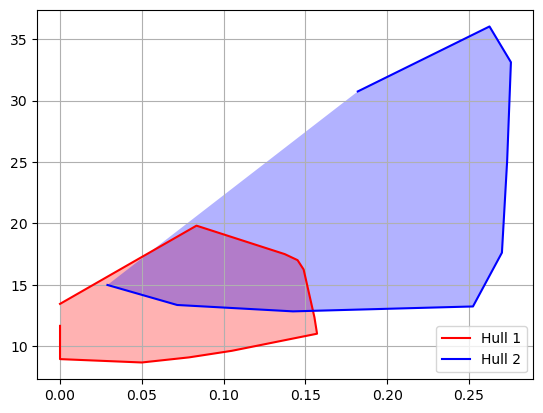

Os dados não são linearmente separáveis.


In [11]:
# Carregar o arquivo CSV em um DataFrame
df = pd.read_csv('Breast Cancer Wisconsin.csv').dropna(axis=1)

# Separar a coluna alvo ('diagnosis') e as colunas de características
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

# Aplicar reducção de dimensionalidade
cols = reduce_dimesionality(X, y)

# Invocar a função para executar o resto do processamento
process_dataset(X[cols], y, 'B', 'M')

#### Segundo Dataset: Classificação IRIS

Fonte: https://www.kaggle.com/datasets/arshid/iris-flower-dataset/data

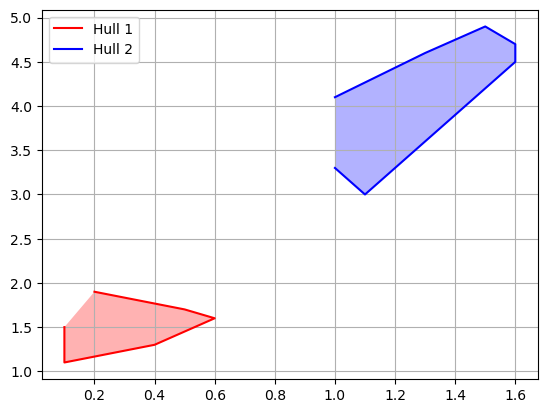

Os dados são linearmente separáveis.
Acurácia do modelo: 100.00%


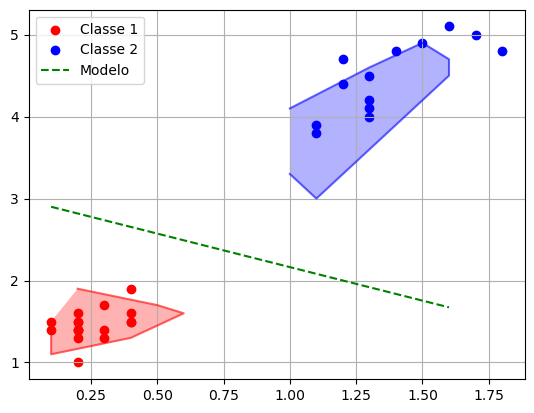

Precisão: 1.00
Revocação: 1.00
F1-Escore: 1.00


In [12]:
# Carregar o arquivo CSV em um DataFrame
df = pd.read_csv('IRIS.csv')

# Selecionar apenas as colunas de interesse
selected_columns = ['sepal_length', 'petal_length', 'species']

# Filtrar apenas as linhas que contêm 'Iris-setosa' ou 'Iris-versicolor'
df_filtered = df[df['species'].isin(['Iris-setosa', 'Iris-versicolor'])]

# Separar a coluna alvo ('diagnosis') e as colunas de características
X = df_filtered.drop(columns=['species'])
y = df_filtered['species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1})

# Aplicar reducção de dimensionalidade
cols = reduce_dimesionality(X, y)

#invocar a função para executar o resto do processamento
process_dataset(X[cols], y, 0, 1)

#### Terceiro Dataset: Titanic

Fonte: https://www.kaggle.com/datasets/heptapod/titanic

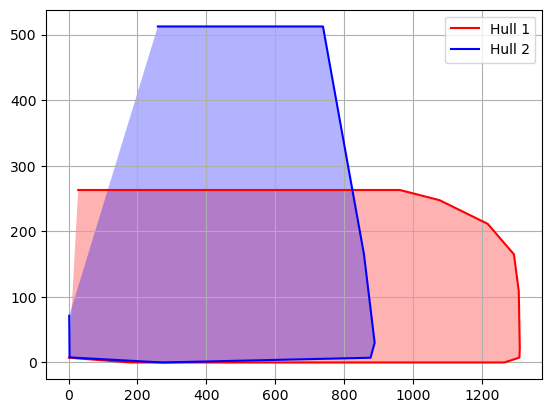

Os dados não são linearmente separáveis.


In [13]:
# Carregar o arquivo CSV em um DataFrame
df = pd.read_csv('Titanic.csv').dropna(axis=1)

# Separar a coluna alvo ('2urvived') e as colunas de características
X = df.drop(columns=['2urvived'])
y = df['2urvived']

# Aplicar reducção de dimensionalidade
cols = reduce_dimesionality(X, y)

#invocar a função para executar o resto do processamento
process_dataset(X[cols], y, 0, 1)

#### Quarto dataset: haberman
Fonte: https://www.kaggle.com/datasets/gilsousa/habermans-survival-data-set

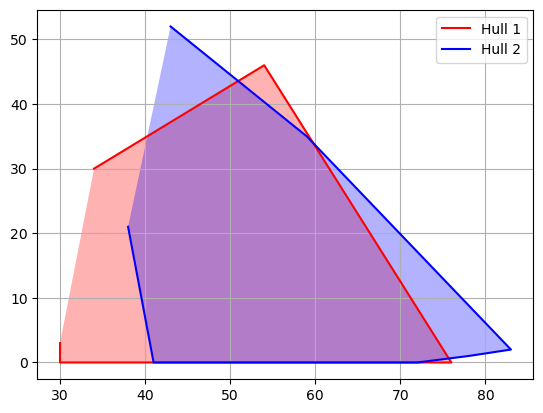

Os dados não são linearmente separáveis.


In [14]:
# Carregar o arquivo CSV em um DataFrame
df = pd.read_csv('haberman.csv').dropna(axis=1)
df.columns = ['Age', 'Op_Year', 'axil_nodes', 'Surv_status']

# Separar a coluna alvo ('Surv_status') e as colunas de características
X = df.drop(columns=['Surv_status'])
y = df.Surv_status.map({1:0,2:1})

# Aplicar reducção de dimensionalidade
cols = reduce_dimesionality(X, y)

#invocar a função para executar o resto do processamento
process_dataset(X[cols], y, 0, 1)

#### Quinto Dataset: Wine Quality Dataset
Fonte: https://www.kaggle.com/datasets/yasserh/wine-quality-dataset

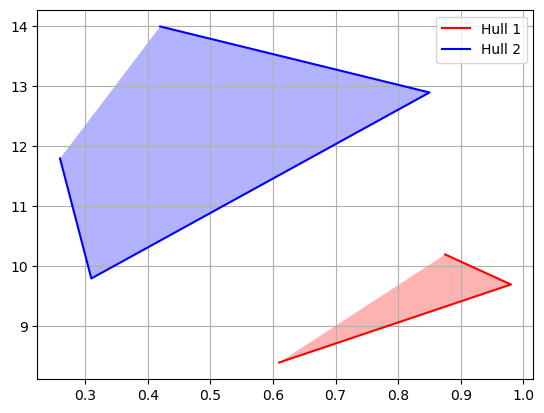

Os dados são linearmente separáveis.
Acurácia do modelo: 100.00%


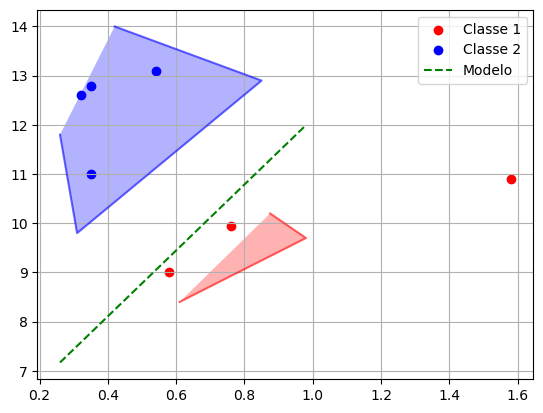

Precisão: 1.00
Revocação: 1.00
F1-Escore: 1.00


In [15]:
# Carregar o arquivo CSV em um DataFrame
df = pd.read_csv('WineQT.csv').dropna(axis=1)

# Filtrar apenas as linhas que contêm as notas 3 e 8
df_filtered = df[df['quality'].isin([3, 8])]

# Separar a coluna alvo ('quality') e as colunas de características
X = df_filtered.drop(columns=['quality', 'sulphates'])
y = df_filtered['quality'].map({3: 0, 8: 1})

# Aplicar reducção de dimensionalidade
cols = reduce_dimesionality(X, y)[::-1]

#invocar a função para executar o resto do processamento
process_dataset(X[cols], y, 0, 1)

#### Sexto Dataset: HeartDisease
Fonte: https://www.kaggle.com/datasets/ketangangal/heart-disease-dataset-uci

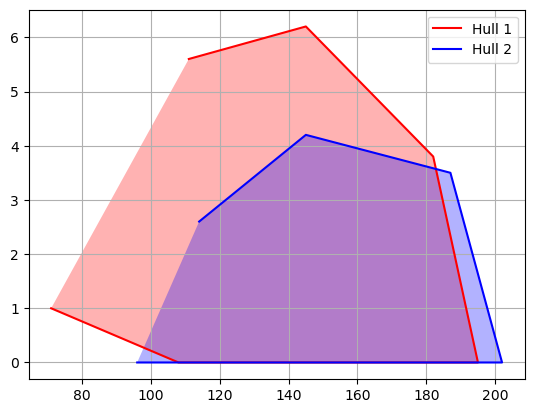

Os dados não são linearmente separáveis.


In [16]:
# Carregar o arquivo CSV em um DataFrame
df = pd.read_csv('HeartDisease.csv').dropna(axis=1)

# Separar a coluna alvo ('target') e as colunas de características
X = df.drop(columns=['target']).select_dtypes(include=[int, float])
y = df['target']

# Aplicar reducção de dimensionalidade
cols = reduce_dimesionality(X, y)

#invocar a função para executar o resto do processamento
process_dataset(X[cols], y, 0, 1)

#### Sétimo Dataset:Ecoli data set

Fonte: https://www.kaggle.com/datasets/kannanaikkal/ecoli-uci-dataset


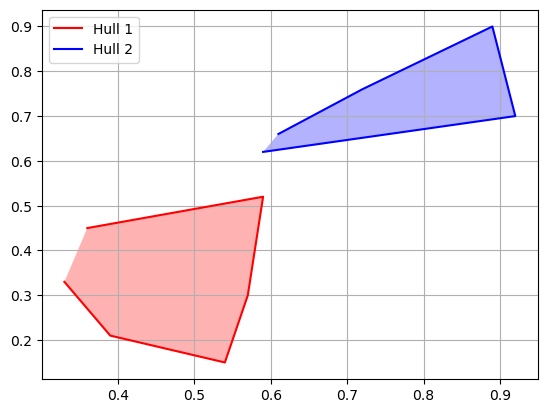

Os dados são linearmente separáveis.
Acurácia do modelo: 94.12%


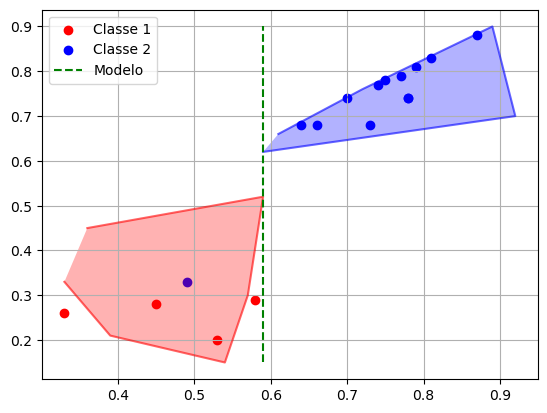

Precisão: 1.00
Revocação: 0.92
F1-Escore: 0.96


In [17]:
# Carregar o arquivo CSV em um DataFrame
df = pd.read_csv('ecoli.csv').dropna(axis=1)

# Filtrar apenas as linhas que contêm  imU e om
df_filtered = df[df['SITE'].isin(["imU", "om"])]

# Separar a coluna alvo ('SITE') e as colunas de características
X = df_filtered.drop(columns=['SITE']).select_dtypes(include=[int, float])
y = df_filtered['SITE'].map({"imU": 1, "om": 0})

# Aplicar reducção de dimensionalidade
cols = reduce_dimesionality(X, y)

#invocar a função para executar o resto do processamento
process_dataset(X[cols], y, 0, 1)

#### Oitavo dataset: Yeast data set
Fonte: https://www.kaggle.com/datasets/samanemami/yeastcsv

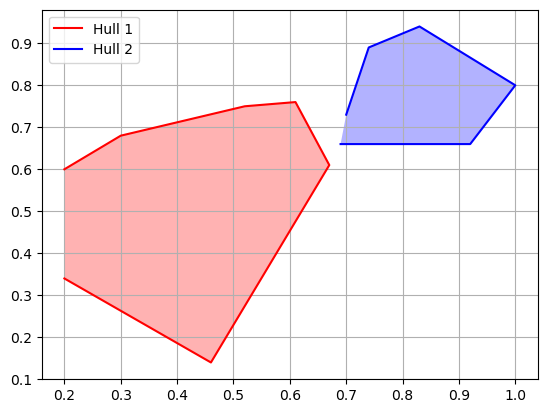

Os dados são linearmente separáveis.
Acurácia do modelo: 93.65%


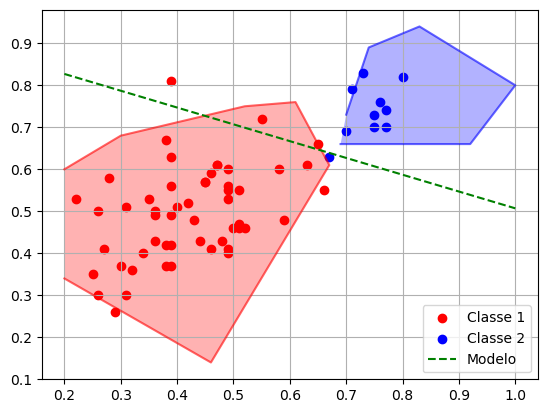

Precisão: 0.75
Revocação: 0.90
F1-Escore: 0.82


In [18]:
# Carregar o arquivo CSV em um DataFrame
df = pd.read_csv('yeast.csv').dropna(axis=1)

# Filtrar apenas as linhas que contêm  ME1 e ME3
df_filtered = df[df['name'].isin(["ME1", "ME3"])]

# Separar a coluna alvo ('name') e as colunas de características
X = df_filtered.drop(columns=['name']).select_dtypes(include=[int, float])
y = df_filtered['name'].map({"ME1": 1, "ME3": 0})

# Aplicar reducção de dimensionalidade
cols = reduce_dimesionality(X, y)

#invocar a função para executar o resto do processamento
process_dataset(X[cols], y, 0, 1)

 #### Nono Dataset: GLASS

Fonte:https://sci2s.ugr.es/keel/dataset.php?cod=20

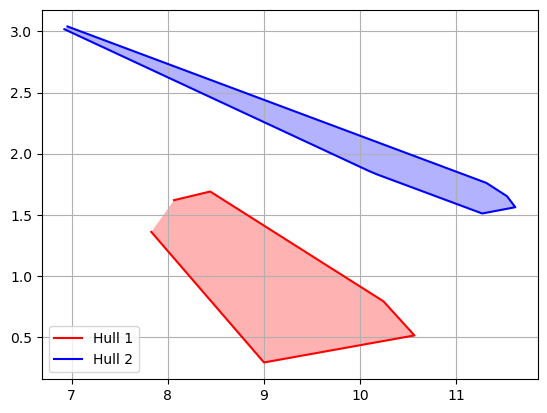

Os dados são linearmente separáveis.
Acurácia do modelo: 56.00%


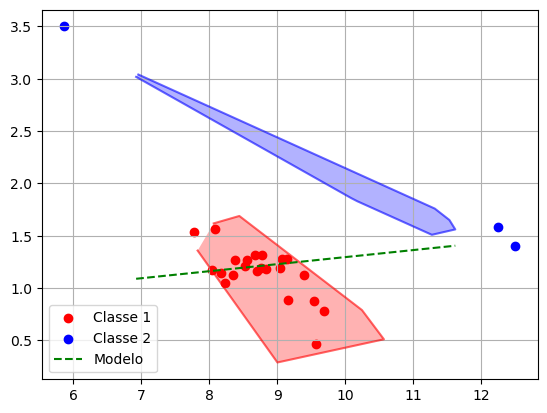

Precisão: 0.17
Revocação: 0.67
F1-Escore: 0.27


In [19]:
# Carregar o arquivo CSV em um DataFrame
df = pd.read_csv('glass.dat',sep=',', skiprows=14)
df.columns = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba','Fe','TypeGlass']

# Filtrar apenas as linhas que contêm  types 1 e 5
df_filtered = df[df['TypeGlass'].isin([1,5])]

# Separar a coluna alvo ('TypeGlass') e as colunas de características
X = df_filtered.drop(columns=['TypeGlass', 'Mg'])
y = df_filtered['TypeGlass'].map({1: 0, 5: 1})

# Aplicar reducção de dimensionalidade
cols = reduce_dimesionality(X, y)[::-1]

#invocar a função para executar o resto do processamento
process_dataset(X[cols], y, 0, 1)

 #### Décimo dataset: contraceptive data set

Fonte:https://sci2s.ugr.es/keel/dataset.php?cod=58



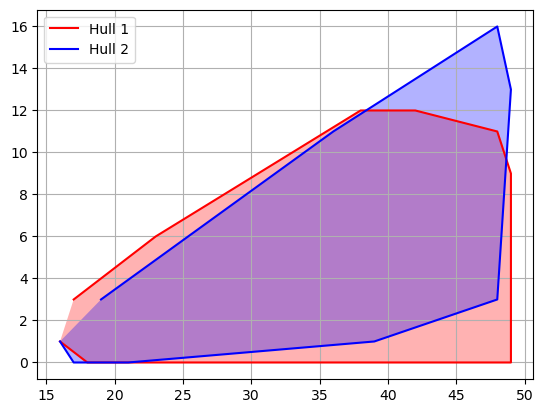

Os dados não são linearmente separáveis.


In [20]:
# Carregar o arquivo CSV em um DataFrame
df = pd.read_csv('contraceptive.dat',sep=',', skiprows=14)
df.columns = ['Wife_age', 'Wife_education', 'Husband_education', 'Children', 'Wife_religion', 'Wife_working', 'Husband_occupation', 'Standard-of-living', 'Media_exposure','Contraceptive_method']

# Filtrar apenas as linhas que contêm  os métodos contraceptivos 1 e 3
df_filtered = df[df['Contraceptive_method'].isin([1,3])]

# Separar a coluna alvo ('Contraceptive_method') e as colunas de características
X = df_filtered.drop(columns=['Contraceptive_method']).select_dtypes([int, float])
y = df_filtered['Contraceptive_method'].map({1: 0, 3: 1})

# Aplicar redução de dimensionalidade
cols = reduce_dimesionality(X, y)

#invocar a função para executar o resto do processamento
process_dataset(X[cols], y, 0, 1)

### Resultados
A análise dos resultados obtidos revelou insights importantes sobre a aplicação prática dos algoritmos de geometria computacional na classificação em aprendizado de máquina supervisionado. Inicialmente, trabalhamos com um conjunto diversificado de 10 datasets, dos quais 5 eram linearmente separáveis e 5 não separáveis. Essa diversidade foi essencial para testar o modelo de maneira abrangente e entender seu desempenho em diferentes cenários.

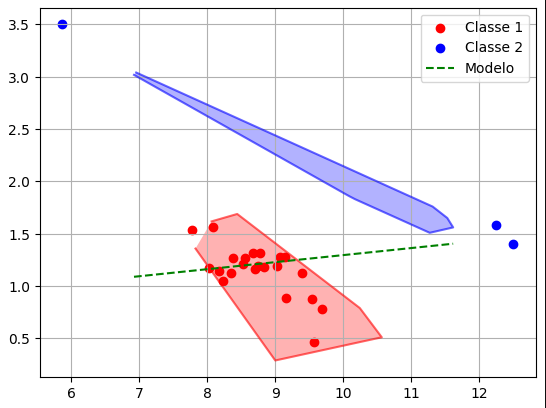



No caso dos datasets linearmente separáveis, observamos uma variabilidade notável na precisão do modelo. Dois desses datasets alcançaram uma precisão de 100%, refletindo uma separação ideal entre as classes. No entanto, um dos datasets obteve apenas 56% de precisão, enquanto outros dois tiveram um desempenho por volta de 90%. Esses resultados mais baixos foram, em parte, esperados, mas podem ser explicados considerando as simplificações feitas durante o processo.

Notamos que, nos casos em que a precisão foi notavelmente baixa, a reta gerada pelo algoritmo, descrita como a reta verde tracejada, não conseguiu separar os dois conjuntos em dois hiperplanos distintos, como se esperaria em datasets linearmente separáveis. Em vez disso, encontramos pontos de ambas as classes presentes nos dois lados da reta. Isso ressalta uma limitação do método de "separação" baseado apenas nos pontos mais próximos, demonstrando que essa abordagem não é suficientemente precisa para alguns datasets. Essa é uma conclusão crucial, indicando que a reta mediatriz dos pontos mais próximos não é sempre uma representação eficaz da separação ideal entre classes.

Além disso, observamos que a reta verde tracejada frequentemente se afastava consideravelmente da reta que de fato separaria os conjuntos. Em muitos casos, a separação ideal seria melhor representada por uma reta vertical entre os valores máximos (x_max_azul) e mínimos (x_min_vermelho) dos conjuntos. Essa discrepância entre a reta mediatriz e a reta ideal provavelmente justifica as taxas de precisão mais baixas observadas. De forma geral, fica claro que a precisão do modelo está diretamente relacionada à qualidade da separação de dados feita pela reta mediatriz dos pontos mais próximos.

Uma observação adicional é que a precisão da linha verde tracejada não foi excelente, devido ao fato de considerarmos apenas os vértices da envoltória, e não os pontos que compõem um segmento da envoltória. Isso indica que uma abordagem mais detalhada na análise da envoltória convexa poderia melhorar o desempenho do modelo. Contudo, os resultados obtidos contribuem para uma compreensão mais profunda dos desafios enfrentados ao utilizar geometria computacional na classificação em aprendizado de máquina supervisionado.

Em resumo, este estudo destaca a importância de uma análise minuciosa dos resultados e da compreensão das limitações inerentes aos algoritmos de geometria computacional na tarefa de classificação.